In [1]:

import time

from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression

from dpyacl.core.stop_criteria import MaxIteration
from dpyacl.experiment import ExperimentAnalyserFactory
from dpyacl.experiment.context import HoldOutExperiment
from dpyacl.metrics import Accuracy
from dpyacl.metrics.evaluation import F1, HammingLoss
from dpyacl.oracle import SimulatedOracle
from dpyacl.scenario.scenario import PoolBasedSamplingScenario
from dpyacl.strategies.single_label import QueryMarginSampling


In [2]:

from dask.distributed import Client
client = Client('tcp://192.168.2.100:8786')
client


Client Scheduler: tcp://192.168.2.100:8786 Dashboard: http://192.168.2.100:8787/status,Cluster Workers: 6 Cores: 12 Memory: 18.00 GB


In [12]:
iterations = []
for i in range (0,1) :
    X,y=load_breast_cancer(return_X_y=True) #import the dataset

    ml_technique = LogisticRegression(solver='sag')
    stopping_criteria = MaxIteration(25)
    query_strategy = QueryMarginSampling()
    performance_metrics = [Accuracy(),  F1(average='weighted'), HammingLoss()]

    # init the ALExperiment
    experiment = HoldOutExperiment(
        client,
        X,
        y,
        scenario_type=PoolBasedSamplingScenario,
        ml_technique=ml_technique,
        performance_metrics=performance_metrics,
        query_strategy=query_strategy,
        oracle=SimulatedOracle(labels=y),
        stopping_criteria=stopping_criteria,
        self_partition=True,
        test_ratio=0.3,
        initial_label_rate=0.05,
        all_class=False,
        rebalance=True,
        batch_size=1
    )

    # experiment = CrossValidationExperiment(
    #     client,
    #     X,
    #     y,
    #     scenario_type=PoolBasedSamplingScenario,
    #     ml_technique=ml_technique,
    #     performance_metrics=performance_metrics,
    #     query_strategy=query_strategy,
    #     oracle=SimulatedOracle(labels=y),
    #     stopping_criteria=stopping_criteria,
    #     self_partition=True,
    #     test_ratio=0.3,
    #     initial_label_rate=0.05,
    #     all_class=False,
    #     rebalance=True
    # )

    start_time = time.time()
    result = experiment.evaluate(client=client, multithread= True, verbose=True)
    end_time = time.time() - start_time
    iterations.append(end_time)


Label: [1], Cost: [1]

| round | initially labeled data | number of queries | cost | accuracy_score: |  f1_score:   | hamming_loss: |
|   0   |    20 (5.03% of all)   |         1         |  0   |   0.848 ± 0.00  | 0.849 ± 0.00 |  0.152 ± 0.00 |Label: [1], Cost: [1]
|   0   |    20 (5.03% of all)   |         2         |  0   |   0.868 ± 0.02  | 0.869 ± 0.02 |  0.132 ± 0.02 |Label: [1], Cost: [1]
|   0   |    20 (5.03% of all)   |         3         |  0   |   0.879 ± 0.02  | 0.880 ± 0.02 |  0.121 ± 0.02 |Label: [1], Cost: [1]
|   0   |    20 (5.03% of all)   |         4         |  0   |   0.886 ± 0.02  | 0.886 ± 0.02 |  0.114 ± 0.02 |Label: [0], Cost: [1]
|   0   |    20 (5.03% of all)   |         5         |  0   |   0.892 ± 0.02  | 0.892 ± 0.02 |  0.108 ± 0.02 |Label: [1], Cost: [1]
|   0   |    20 (5.03% of all)   |         6         |  0   |   0.895 ± 0.02  | 0.894 ± 0.02 |  0.105 ± 0.02 |Label: [0], Cost: [1]
|   0   |    20 (5.03% of all)   |         7         |  0   |   0.897 ± 0.

[33.71197462081909]


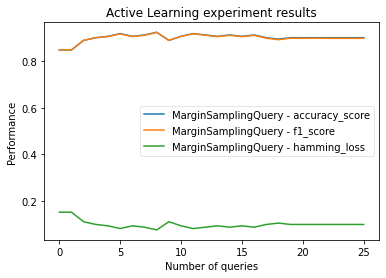

In [13]:
print(iterations)

query_analyser = ExperimentAnalyserFactory.experiment_analyser(
                    performance_metrics=[metric.metric_name for metric in performance_metrics],
                    method_name=query_strategy.query_function_name,
                    method_results=result,
                    type="queries"
                )
# get a brief description of the experiment
query_analyser.plot_learning_curves(title='Active Learning experiment results')